<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/9.modern_recurrent_neural_networks/9_7_%1Dsequence_to_sequence_%1Dlearning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import torch
from torch import nn
from torch.nn import functional as F
import collections
import re
import hashlib
import os
import tarfile
import zipfile
import requests
import matplotlib.pyplot as plt
import random
import torch
from torch.nn import functional as F
from torch import nn
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data

In [129]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [130]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

In [131]:
raw_text = read_data_nmt()
raw_text[:50]

'Go.\tVa !\nHi.\tSalut !\nRun!\tCours\u202f!\nRun!\tCourez\u202f!\nWh'

In [132]:
def preprocess_nmt(text):

  def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' '
  text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
  out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
  return ''.join(out)

In [133]:
text = preprocess_nmt(raw_text)

In [134]:
print(text[:50])

go .	va !
hi .	salut !
run !	cours !
run !	courez 


In [135]:
def tokenize_nmt(text, num_examples=None):

  source, target = [], []
  for i,line in enumerate(text.split('\n')):
    if num_examples and i > num_examples:
      break;
    parts = line.split('\t')
    if len(parts) == 2:
      source.append(parts[0].split(' '))
      target.append(parts[1].split(' '))

  return source, target

In [136]:
source, target = tokenize_nmt(text)
source[:6]

[['go', '.'],
 ['hi', '.'],
 ['run', '!'],
 ['run', '!'],
 ['who', '?'],
 ['wow', '!']]

In [137]:
target[:6]

[['va', '!'],
 ['salut', '!'],
 ['cours', '!'],
 ['courez', '!'],
 ['qui', '?'],
 ['ça', 'alors', '!']]

In [138]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):

  # plt.set_figsize()
  _, _, patches = plt.hist([[len(l) for l in list(xlist)], [len(l) for l in list(ylist)]], 10)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  for patch in patches[1].patches:
    patch.set_hatch('/')
  plt.legend(legend)

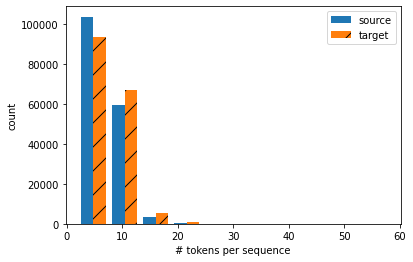

In [139]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence', 'count', source, target);

In [140]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def tokenize(lines, token='word'):

  if token == 'word':
    return [line.split() for line in lines]
  elif token == 'char':
    return [list(line) for line in lines]
  else:
    print('ERROR: unknow token type: ' + token)

def count_corpus(tokens):

  if len(tokens) == 0 or isinstance(tokens[0], list):
   tokens = [token for line in tokens for token in line]
  return collections.Counter(tokens)

class Vocab:

  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):

    if tokens is None:
      tokens = []
    if reserved_tokens is None:
      reserved_tokens = []
    counter = count_corpus(tokens)

    self._token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse=True)
    self.idx_to_token = ['<unk>'] + reserved_tokens
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    for token, freq in self._token_freqs:
      if freq < min_freq:
        break;
      if token not in self.token_to_idx:
        self.idx_to_token.append(token)
        self.token_to_idx[token] = len(self.idx_to_token) - 1
  
  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    else:
      return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    else:
      return [self.to_tokens(idx) for idx in indices]

  @property
  def unk(self):
    return 0

  @property
  def token_freqs(self):
    return self._token_freqs

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [141]:
src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [172]:
src_vocab['hello']

115

In [142]:
target_vocab = Vocab(target, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(target_vocab)

17851

In [143]:
def truncate_pad(line, num_steps, padding_token):

  if len(line) > num_steps:
    return line[:num_steps]
  
  return line + [padding_token] * (num_steps - len(line))

In [144]:
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [145]:
def build_array_nmt(lines, vocab, num_steps):

  lines = [vocab[l] for l in lines]
  lines = [l + [vocab['<eos>']] for l in lines]
  array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
  valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)

  return array, valid_len

In [146]:
build_array_nmt([source[0], source[1]], src_vocab, 10)

(tensor([[  47,    4,    3,    1,    1,    1,    1,    1,    1,    1],
         [2944,    4,    3,    1,    1,    1,    1,    1,    1,    1]]),
 tensor([3, 3]))

In [147]:
def load_data_nmt(batch_size, num_steps, num_examples=600):

  text = preprocess_nmt(read_data_nmt())
  source, target = tokenize_nmt(text, num_examples)
  src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
  tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])

  src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
  tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

  data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
  data_iter = load_array(data_arrays, batch_size)

  return data_iter, src_vocab, tgt_vocab

In [148]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:

  print('X:', X.type(torch.int32))
  print('valid lengths for X:', X_valid_len)
  print('Y:', Y.type(torch.int32))
  print('valid lengths for Y:', Y_valid_len)
  break

X: tensor([[18,  6, 64, 11,  3,  1,  1,  1],
        [40, 27,  5,  3,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for X: tensor([5, 4])
Y: tensor([[ 79, 136,   9,   3,   1,   1,   1,   1],
        [ 52,  13,   0,   5,   3,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([4, 5])


In [149]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [150]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [151]:
class Seq2SeqEncoder(Encoder):

  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):

    super(Seq2SeqEncoder, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)
  
  def forward(self, X, *args):

    # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
    X = self.embedding(X)
    X = X.permute(1, 0, 2)

    output, state = self.rnn(X)

    return output, state

In [152]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()

Seq2SeqEncoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(8, 16, num_layers=2)
)

In [153]:
X = torch.zeros((4, 7), dtype=torch.long)

In [154]:
output, state = encoder(X)

In [155]:
output.shape

torch.Size([7, 4, 16])

In [156]:
state.shape

torch.Size([2, 4, 16])

In [157]:
class Seq2SeqDecoder(Decoder):

  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
    
    super(Seq2SeqDecoder, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, *args):
    return enc_outputs[1]

  def forward(self, X, state):

    X = self.embedding(X).permute(1, 0, 2)
    context = state[-1].repeat(X.shape[0], 1, 1)
    X_and_context = torch.cat((X, context), 2)
    output, state = self.rnn(X_and_context, state)
    output = self.dense(output).permute(1, 0, 2)
    return output, state

In [158]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)

In [159]:
output.shape

torch.Size([4, 7, 10])

In [160]:
state.shape

torch.Size([2, 4, 16])

In [161]:
def sequence_mask(X, valid_len, value=0):

  maxlen = X.size(1)
  mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
  X[~mask] = value
  return X

In [162]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [163]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):

  def forward(self, pred, label, valid_len):
    weights = torch.ones_like(label)
    weights = sequence_mask(weights, valid_len)
    unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
    weighted_loss = (unweighted_loss * weights)
    return unweighted_loss

In [164]:
loss = MaskedSoftmaxCELoss()

In [165]:
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor(2.3026)

In [166]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):

  def xavier_init_weights(m):
    if type(m) == nn.Linear:
      nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if "weight" in param:
          nn.init.xavier_uniform_(m._parameters[param])
    
  net.apply(xavier_init_weights)
  net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss = MaskedSoftmaxCELoss()
  net.train()

  ui_x = []
  ui_y = []
  for epoch in range(num_epochs):
    timer = Timer()
    metric = Accumulator(2)
    for batch in data_iter:

      optimizer.zero_grad()
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                              device=device).reshape(-1, 1)
      dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
      Y_hat, _ = net(X, dec_input, X_valid_len)
      l = loss(Y_hat, Y, Y_valid_len)
      l.sum().backward()
      grad_clipping(net, 1)
      num_tokens = Y_valid_len.sum()
      optimizer.step()
      with torch.no_grad():
        metric.add(l.sum(), num_tokens)
    if (epoch + 1) % 10 == 0:
        ui_x.append(epoch + 1)
        ui_y.append(metric[0] / metric[1])

  plt.plot(ui_x, ui_y, 'r')
  plt.show()
  print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} ' f'tokens/sec on {str(device)}')

In [167]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, try_gpu()
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

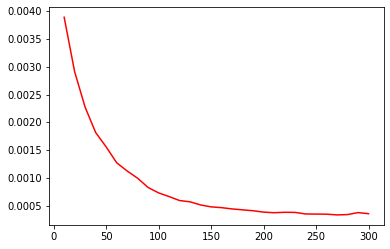

loss 0.000, 7891.1 tokens/sec on cpu


In [168]:
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [175]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):

  net.eval()
  src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
  enc_valid_len = torch.tensor([len(src_tokens)], device=device)
  src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
  enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
  enc_outputs = net.encoder(enc_X, enc_valid_len)
  dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
  dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
  output_seq, attention_weight_seq = [], []

  for _ in range(num_steps):

    Y, dec_state = net.decoder(dec_X, dec_state)
    dec_X = Y.argmax(dim=2)
    pred = dec_X.squeeze(dim=0).type(torch.int32).item()
    if save_attention_weights:
      attention_weight_seq.append(net.decoder.attention_weights)
    if pred == tgt_vocab['<eos>']:
      break
    output_seq.append(pred)
  return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [180]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
eng = 'he\'s calm .'
predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)

('il est paresseux !', [])

In [182]:
label_subs = collections.defaultdict(int)

In [183]:
label_subs['ABC'] = 1

In [185]:
label_subs['ABBC']

0